## Pembuatan Model Deep Learning LSTM-GRU, Prediksi Harga Komoditas Pangan Pasar Kramat Kota Cirebon.

Authored by : Hafiz Caniago.

## Setup Variabel

In [32]:
# Dapat Dirubah
## List Komoditas
comodity_list = ['bawang_merah', 'cabai_merah_besar', 'cabai_merah_keriting', 'cabai_rawit_hijau', 'cabai_rawit_merah'];
# Pilih Komoditas :
# 0 = bawang merah, 1 = cabai merah besar, 2 = cabai merah keriting,
# 3 = cabai rawit hijau, 4 = cabai rawit merah
comodity_selected = 0;

## Hyperparameter
set_max_epochs = 100; # 100, 150
set_neurons = 16; # 16, 32, 64
set_batch_size = 32; # 32

# Tidak Dirubah
set_test_size = 0.2; # Panjang Data Test
set_window_size = 30; # Panjang Data Pola Time Series

## Kode Tambahan
y_axis_title_comodity = ['Harga Bawang Merah', 'Harga Cabai Merah Besar',
                         'Harga Cabai Merah Keriting', 'Harga Cabai Rawit Hijau',
                         'Harga Cabai Rawit Merah']
chart_title = 'Historis Data ' + y_axis_title_comodity[comodity_selected]

## Import Library

In [33]:
# numpy & matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Sklearn Lib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

# Tensorflow
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# JobLib
import joblib

In [34]:
# Export requirements.txt
!pip freeze > requirements.txt

## Data Preparation


In [35]:
# Baca CSV File
df = pd.read_csv('/content/dataset.csv')

In [36]:
# Preview Data
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000,37000,32000,60000,29000
1,2021-05-04,39000,39000,29000,70000,29000
2,2021-05-05,37000,37000,28000,70000,29000
3,2021-05-06,39000,39000,28000,70000,29000
4,2021-05-07,39000,40000,30000,70000,31000
...,...,...,...,...,...,...
1092,2024-04-29,60000,60000,32000,49000,60000
1093,2024-04-30,60000,60000,30000,49000,60000
1094,2024-05-01,59500,60000,33000,49000,57500
1095,2024-05-02,59000,60000,36000,49000,55000


In [37]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  1097 non-null   object
 1   cabai_merah_besar     1097 non-null   int64 
 2   cabai_merah_keriting  1097 non-null   int64 
 3   cabai_rawit_hijau     1097 non-null   int64 
 4   cabai_rawit_merah     1097 non-null   int64 
 5   bawang_merah          1097 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 51.6+ KB


In [38]:
df.describe()

,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,42176.162261,46441.886964,39445.077484,58527.803099,33160.893345
std,19287.677455,18727.108870,13950.812254,20627.575250,8924.155856
min,16000.000000,17000.000000,17000.000000,24500.000000,19000.000000
25%,29000.000000,34500.000000,31000.000000,43682.000000,28500.000000
50%,35500.000000,41000.000000,36000.000000,54000.000000,31000.000000
75%,50000.000000,60000.000000,46333.000000,70000.000000,35500.000000
max,110000.000000,105000.000000,100000.000000,120000.000000,70000.000000




> dari hasil deskripsi dari data, terdapat 5 kolom dataset komoditas pangan dengan masing masing data berjumlah 1097 baris.
- harga cabai merah besar
  - max : 110,000
  - min : 16,000
- harga cabai merah keriting
  - max : 105,000
  - min : 17,000
- harga cabai rawit hijau
  - max : 100,000
  - min : 17,000
- harga cabai rawit merah
  - max : 120,000
  - min : 16,000
- harga bawang merah
  - max : 70,000
  - min : 19,000



> Kode dibawah ini akan menstransformasikan kolom 'date' dari tipe data object ke tipe data date, serta melakukan konversi bentuk tanggal untuk 'date' jika tidak berformat 'Y-m-d'. serta melakukan konversi tipe data harga ke dalam bentuk float.



In [39]:
# Mentransformasikan Data ke Format Datetime
df.date = pd.to_datetime(df.date, format = '%Y-%m-%d')
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Mentransformasikan Data ke Format Integer (Harga Pangan tidak perlu koma)
columns_to_convert = df.columns[1:]  # Exclude the 'date' column
df[columns_to_convert] = df[columns_to_convert].astype('float64')

In [40]:
# Dataset info after transformation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1097 non-null   datetime64[ns]
 1   cabai_merah_besar     1097 non-null   float64       
 2   cabai_merah_keriting  1097 non-null   float64       
 3   cabai_rawit_hijau     1097 non-null   float64       
 4   cabai_rawit_merah     1097 non-null   float64       
 5   bawang_merah          1097 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 51.6 KB


In [41]:
# Preview Data after transformation
df

,date,cabai_merah_besar,cabai_merah_keriting,cabai_rawit_hijau,cabai_rawit_merah,bawang_merah
0,2021-05-03,39000.0,37000.0,32000.0,60000.0,29000.0
1,2021-05-04,39000.0,39000.0,29000.0,70000.0,29000.0
2,2021-05-05,37000.0,37000.0,28000.0,70000.0,29000.0
3,2021-05-06,39000.0,39000.0,28000.0,70000.0,29000.0
4,2021-05-07,39000.0,40000.0,30000.0,70000.0,31000.0
...,...,...,...,...,...,...
1092,2024-04-29,60000.0,60000.0,32000.0,49000.0,60000.0
1093,2024-04-30,60000.0,60000.0,30000.0,49000.0,60000.0
1094,2024-05-01,59500.0,60000.0,33000.0,49000.0,57500.0
1095,2024-05-02,59000.0,60000.0,36000.0,49000.0,55000.0


In [42]:
# Panjang Data
print("Panjang Data : ", len(df))

Panjang Data :  1097


In [43]:
# Check Duplicates data
df.duplicated(subset=['date'])

,0
0,False
1,False
2,False
3,False
4,False
...,...
1092,False
1093,False
1094,False
1095,False


In [44]:
# Check Null Data
df.isnull().sum().sum()

np.int64(0)

### Preview Chart Comodity

In [45]:
# Ploting Chart Data Historis
fig = px.line(y=df[comodity_list[comodity_selected]], x=df.date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Waktu Historis",
                  yaxis_title=y_axis_title_comodity[comodity_selected],
                  title={'text': chart_title, 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

### Normalisasi, Split Data Training & Testing, Pembentukan Pola Time Series



> Mempersiapkan instance scaler dan mengeluarkan file format scaler.pkl agar model bisa digunakan di luar google colab. (contoh : inference menggunakan model dan skalar yang sudah di export)



In [46]:
# Data Scaling
scaler = MinMaxScaler()
scaler.fit(df[comodity_list[comodity_selected]].values.reshape(-1,1))

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']



> menyiapkan variable yang menampung jumlah atau ukuran data testing (20%)



In [47]:
# Set Panjang Data Test
test_size = int(len(df) * set_test_size)
test_size

219



> Melakukan visualisasi untuk menggambarkan seberapa banyak data training dan data testing



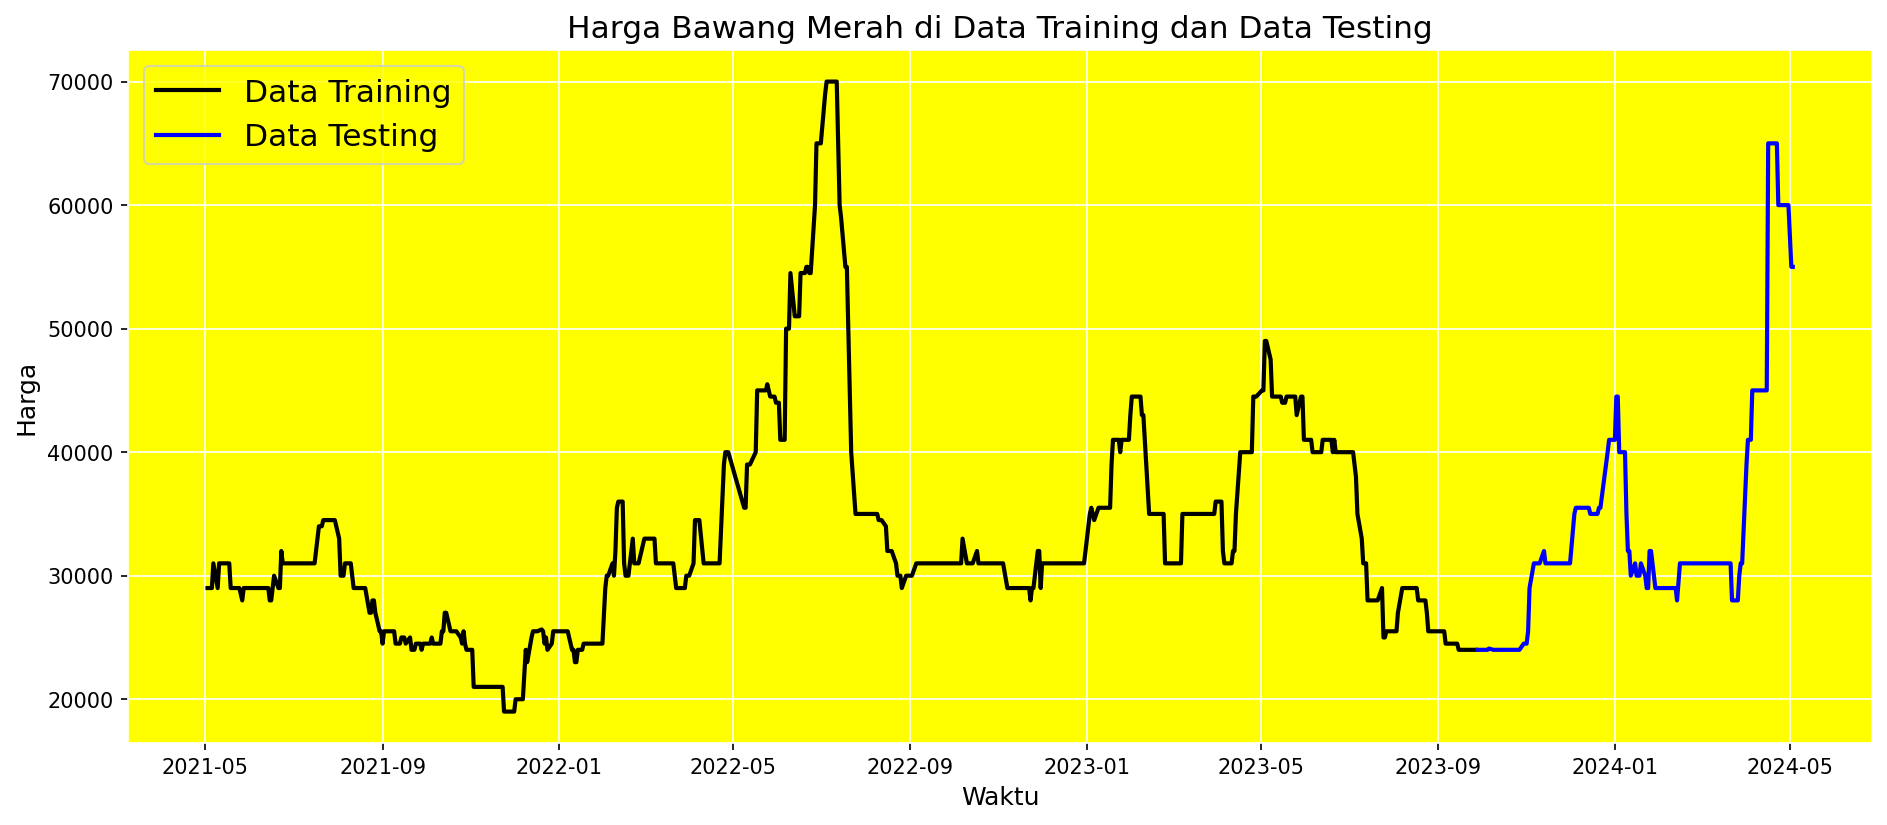

In [48]:
# Ploting Data Training dan Test
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date[:-test_size], df[comodity_list[comodity_selected]][:-test_size], color='black', lw=2)
plt.plot(df.date[-test_size:], df[comodity_list[comodity_selected]][-test_size:], color='blue', lw=2)
plt.title(y_axis_title_comodity[comodity_selected] + ' di Data Training dan Data Testing', fontsize=15)
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(['Data Training', 'Data Testing'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- menyiapkan ukuran window_size
- menyiapkan data training (80%) data
- melakukan normalisasi pada data training dan membatasi angka koma menjadi 6 agar proses komputasi bisa lebih ringan.
- menyiapkan variable X_Train yang menyimpan data dalam bentuk window, dengan setiap window tersebut memiliki panjang 30 data (cek deklarasi di awal).
- menyiapkan variable y_train sebagai nilai aktual yang akan diprediksi menggunakan data pada setiap window.

In [49]:
# Panjang data Loopback x hari
window_size = set_window_size

# Persiapkan data Training 80% dari data, dan normalisasikan
train_data = df[comodity_list[comodity_selected]][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
train_data = np.round(train_data, 6)

# Siapkan Variable untuk menampung data Train, disesuaikan dengan data loopback yaitu 30
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])

In [50]:
print("Panjang Data Train : ", len(train_data))
print("Panjang Data Train X - loopback : ", len(X_train))
print("Panjang Data Train y - loopback : ", len(y_train))

Panjang Data Train :  878
Panjang Data Train X - loopback :  848
Panjang Data Train y - loopback :  848




> sama saja dengan proses pembentukan pada data training, pembagian data testing menggunakan 20% dari dataset



In [51]:
# Persiapkan data test
test_data = df[comodity_list[comodity_selected]][-test_size-30:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

# Membulatkan hingga 6 angka di belakang koma
test_data = np.round(test_data, 6)

# Siapkan Variable untuk menampung data Test, disesuaikan dengan data loopback yaitu 30
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-30:i, 0])
    y_test.append(test_data[i, 0])

In [52]:
print("Panjang Data Test : ", len(test_data))
print("Panjang Data Test X - loopback : ", len(X_test))
print("Panjang Data Test y - loopback : ", len(y_test))

Panjang Data Test :  249
Panjang Data Test X - loopback :  219
Panjang Data Test y - loopback :  219




> setelahnya data tersebut akan dirubah menjadi bentuk array dan akan dilakukan reshape agar format datanya menjadi format tensor (format yang digunakan pada pelatihan deep learning)



In [53]:
# Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list.
# We need to convert them to numpy arrays with a higher dimension,
# which is the data format accepted by TensorFlow when training the neural network:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (848, 30, 1)
y_train Shape:  (848, 1)
X_test Shape:   (219, 30, 1)
y_test Shape:   (219, 1)


## Training Model


> Training model dilakukan dengan arsitektur sebagai berikut :



In [54]:
# Create LSTM + GRU Model
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = set_neurons, return_sequences=True)(input1)
    x = GRU(units = set_neurons)(x)  # Setting return_sequences=False to get 2D output
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=Adam())
    model.summary()

    return model



> Proses training model dilakukan juga dengan memanfaatkan model checkpoint agar model terbaik dapat diperoleh dari pelatihan dan disimpan dalam bentuk h5 file.



In [55]:
# Training Model
model = define_model()
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# Fit the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=set_max_epochs, batch_size=set_batch_size, validation_split=0.1, verbose=1, callbacks=[checkpoint])
# Load the best model saved during training
model = load_model('best_model.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,801 (10.94 KB)

 Trainable params: 2,801 (10.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1127
Epoch 1: val_loss improved from inf to 0.02297, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0973 - val_loss: 0.0230
Epoch 2/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0163
Epoch 2: val_loss improved from 0.02297 to 0.00670, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0159 - val_loss: 0.0067
Epoch 3/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102
Epoch 3: val_loss did not improve from 0.00670
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 4/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053
Epoch 4: val_loss improved from 0.00670 to 0.00251, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 5/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037
Epoch 5: val_loss did not improve from 0.00251
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 6/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035
Epoch 6: val_loss improved from 0.00251 to 0.00218, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 7/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026
Epoch 7: val_loss improved from 0.00218 to 0.00121, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 8/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 8: val_loss did not improve from 0.00121
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 9: val_loss did not improve from 0.00121
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 10/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 10: val_loss did not improve from 0.00121
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 11: val_loss did not improve from 0.00121
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 12/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 12: val_loss did not improve from 0.00121
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 9.9359e-04
Epoch 14/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 14: val_loss did not improve from 0.00099
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 15/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 15: val_loss improved from 0.00099 to 0.00087, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 8.6749e-04
Epoch 16/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 16: val_loss did not improve from 0.00087
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 17/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 17: val_loss did not improve from 0.00087
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 18/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 18: val_loss improved from 0.00087 to 0.00082, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 8.1571e-04
Epoch 19/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7940e-04
Epoch 19: val_loss did not improve from 0.00082
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 9.5632e-04
Epoch 20/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4147e-04
Epoch 20: val_loss did not improve from 0.00082
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7712e-04 - val_loss: 0.0010
Epoch 21/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 21: val_loss improved from 0.00082 to 0.00073, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 7.3324e-04
Epoch 22/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1777e-04
Epoch 22: val_loss did not improve from 0.00073
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7293e-04 - val_loss: 9.7554e-04
Epoch 23/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 23: val_loss improved from 0.00073 to 0.00068, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 6.8181e-04
Epoch 24/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 24: val_loss improved from 0.00068 to 0.00057, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 5.7116e-04
Epoch 25/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 25: val_loss did not improve from 0.00057
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 26/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 26: val_loss did not improve from 0.00057
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 27/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 27: val_loss did not improve from 0.00057
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 8.9836e-04
Epoch 28/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 28: val_loss did not improve from 0.00057
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 6.5564e-04
Epoch 29/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4801e-04
Epoch 29: val_loss did not improve from 0.00057
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.7627e-04 - val_loss: 5.3458e-04
Epoch 32/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3224e-04
Epoch 32: val_loss did not improve from 0.00053
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.3912e-04 - val_loss: 6.9853e-04
Epoch 33/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5469e-04
Epoch 33: val_loss improved from 0.00053 to 0.00049, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4513e-04 - val_loss: 4.9084e-04
Epoch 34/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2623e-04
Epoch 34: val_loss did not improve from 0.00049
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3442e-04 - val_loss: 7.5651e-04
Epoch 35/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7078e-04
Epoch 35: val_loss improved from 0.00049 to 0.00039, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4063e-04 - val_loss: 3.9295e-04
Epoch 36/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 36: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - val_loss: 5.1582e-04
Epoch 37/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4991e-04
Epoch 37: val_loss improved from 0.00039 to 0.00039, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5354e-04 - val_loss: 3.8790e-04
Epoch 38/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2427e-04
Epoch 38: val_loss did not improve from 0.00039
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2986e-04 - val_loss: 4.0181e-04
Epoch 39/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8932e-04
Epoch 39: val_loss improved from 0.00039 to 0.00035, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0385e-04 - val_loss: 3.4609e-04
Epoch 40/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1151e-04
Epoch 40: val_loss did not improve from 0.00035
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8697e-04 - val_loss: 7.1048e-04
Epoch 41/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3581e-04
Epoch 41: val_loss did not improve from 0.00035
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4404e-04 - val_loss: 4.5587e-04
Epoch 42/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8247e-04
Epoch 42: val_loss did not improve from 0.00035
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8291e-04 - val_loss: 4.8485e-04
Epoch 43/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7080e-04
Epoch 43: val_loss did not improve from 0.00035
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4328e-04 - val_loss: 4.6890e-04
Epoch 44/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2278e-04
Epoch 44: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1180e-04 - val_loss: 3.0733e-04
Epoch 53/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7811e-04
Epoch 53: val_loss did not improve from 0.00031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5124e-04 - val_loss: 3.5374e-04
Epoch 54/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6153e-04
Epoch 54: val_loss did not improve from 0.00031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6546e-04 - val_loss: 3.7259e-04
Epoch 55/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9611e-04
Epoch 55: val_loss did not improve from 0.00031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5714e-04 - val_loss: 3.1631e-04
Epoch 56/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2310e-04
Epoch 56: val_loss did not improve from 0.00031
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2826e-04 - val_loss: 4.4093e-04
Epoch 57/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0936e-04
Epoch 57: val_loss did not improve from 0.0003

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2475e-04 - val_loss: 2.9011e-04
Epoch 63/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4990e-04
Epoch 63: val_loss did not improve from 0.00029
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4012e-04 - val_loss: 4.2124e-04
Epoch 64/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4497e-04
Epoch 64: val_loss did not improve from 0.00029
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5615e-04 - val_loss: 4.0842e-04
Epoch 65/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9395e-04
Epoch 65: val_loss improved from 0.00029 to 0.00028, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9969e-04 - val_loss: 2.8302e-04
Epoch 66/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6676e-04
Epoch 66: val_loss did not improve from 0.00028
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4978e-04 - val_loss: 3.2411e-04
Epoch 67/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7613e-04
Epoch 67: val_loss improved from 0.00028 to 0.00024, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9028e-04 - val_loss: 2.3828e-04
Epoch 68/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5954e-04
Epoch 68: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5291e-04 - val_loss: 2.9212e-04
Epoch 69/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0437e-04
Epoch 69: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9569e-04 - val_loss: 2.8649e-04
Epoch 70/100
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8081e-04
Epoch 70: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7592e-04 - val_loss: 3.2951e-04
Epoch 71/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5951e-04
Epoch 71: val_loss improved from 0.00024 to 0.00024, saving model to best_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6020e-04 - val_loss: 2.3595e-04
Epoch 72/100
20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6922e-04
Epoch 72: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.6062e-04 - val_loss: 2.5867e-04
Epoch 73/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7738e-04
Epoch 73: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6917e-04 - val_loss: 3.6417e-04
Epoch 74/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8478e-04
Epoch 74: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8307e-04 - val_loss: 2.4773e-04
Epoch 75/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6136e-04
Epoch 75: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4572e-04 - val_loss: 3.6481e-04
Epoch 76/100
16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9776e-04
Epoch 76: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0054e-04 - val_loss: 2.3527e-04
Epoch 79/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3920e-04
Epoch 79: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4038e-04 - val_loss: 2.5304e-04
Epoch 80/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7808e-04
Epoch 80: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7362e-04 - val_loss: 2.7832e-04
Epoch 81/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6935e-04
Epoch 81: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5873e-04 - val_loss: 3.6722e-04
Epoch 82/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5395e-04
Epoch 82: val_loss did not improve from 0.00024
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1912e-04 - val_loss: 2.5795e-04
Epoch 83/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4704e-04
Epoch 83: val_loss did not improve from 0.000

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9083e-04 - val_loss: 2.2490e-04
Epoch 85/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0896e-04
Epoch 85: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0771e-04 - val_loss: 3.0672e-04
Epoch 86/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0766e-04
Epoch 86: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1657e-04 - val_loss: 2.9549e-04
Epoch 87/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3780e-04
Epoch 87: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2915e-04 - val_loss: 3.1901e-04
Epoch 88/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1074e-04
Epoch 88: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3435e-04 - val_loss: 2.8564e-04
Epoch 89/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2010e-04
Epoch 89: val_loss did not improve from 0.0002

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8265e-04 - val_loss: 2.2389e-04
Epoch 95/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9818e-04
Epoch 95: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1939e-04 - val_loss: 2.4989e-04
Epoch 96/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4156e-04
Epoch 96: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4105e-04 - val_loss: 4.9666e-04
Epoch 97/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3748e-04
Epoch 97: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3792e-04 - val_loss: 4.3771e-04
Epoch 98/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4772e-04
Epoch 98: val_loss did not improve from 0.00022
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5511e-04 - val_loss: 3.1428e-04
Epoch 99/100
17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9230e-04
Epoch 99: val_loss did not improve from 0.00

## Evaluasi Model



> Evaluasi model dilakukan pada data yang masih dalam bentuk normalisasi dan menggunakan metriks MSE, RMSE, MAPE, dan Accuracy



In [56]:
# Model Evaluation (Data Normalisasi)
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
# Membulatkan angka koma normalisasi maksimal 6
y_pred = np.round(y_pred, 6)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5006e-04  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [57]:
# Calculate Evaluation Value of Model
MAPE = mean_absolute_percentage_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
Accuracy = 1 - MAPE

print("Test Loss (MSE):", result) # MSE
print("Test RMSE:", RMSE)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss (MSE): 0.001283841673284769
Test RMSE: 0.035830704050416454
Test MAPE: 0.055082837673021724
Test Accuracy: 0.9449171623269783




> Evaluasi dilakukan lagi, namun kali ini saya ingin mencoba melihat evaluasinya dalam bentuk data yang sudah di denormalisasi, hal ini saya lakukan untuk mengetahui hasil evaluasi jika pada data ril



In [58]:
# Kalkulasi Evaluasi Model (Data Denormalisasi / Asli)
y_test_true_dn = np.round(scaler.inverse_transform(y_test)) # Dibulatkan
y_test_pred_dn = np.round(scaler.inverse_transform(y_pred)) # Dibulatkan

mse = mean_squared_error(y_test_true_dn, y_test_pred_dn)
rmse = root_mean_squared_error(y_test_true_dn, y_test_pred_dn)
mape = mean_absolute_percentage_error(y_test_true_dn, y_test_pred_dn) * 100

print(f"Test MSE on denormalized data: {mse}")
print(f"Test RMSE on denormalized data: {rmse}")
print(f"Test MAPE on denormalized data: {mape}%")

Test MSE on denormalized data: 3339151.7671232875
Test RMSE on denormalized data: 1827.3346073238167
Test MAPE on denormalized data: 2.275950172659254%




> melakukan visualiasi untuk melihat bagaimana performa model untuk memprediksi



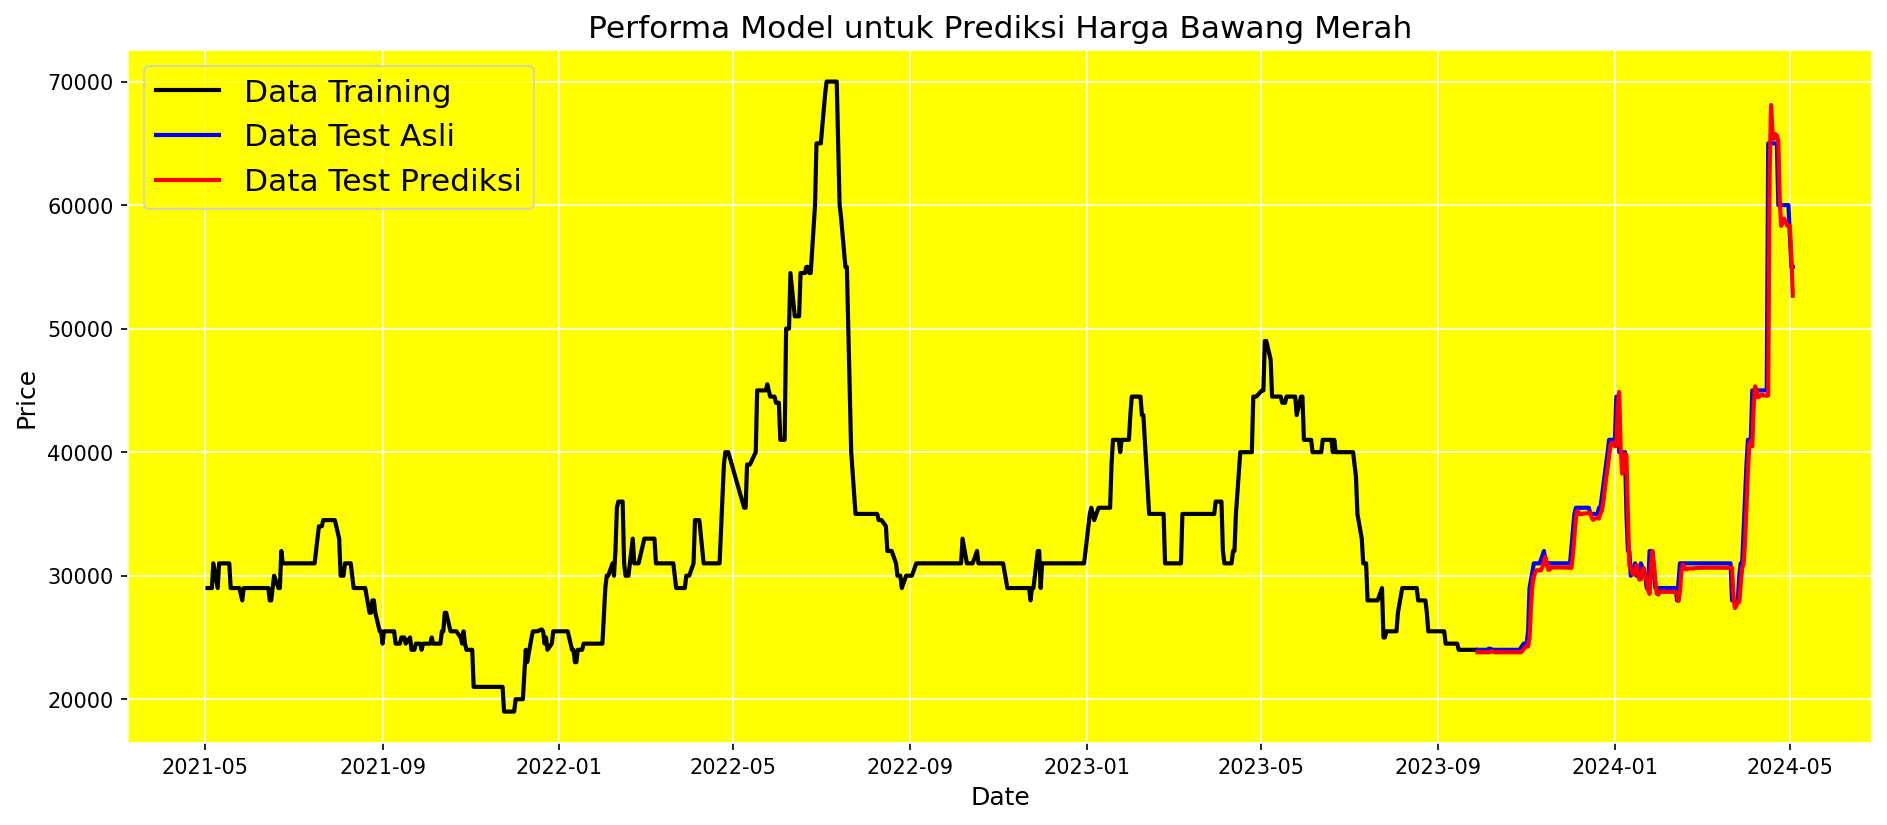

In [59]:
# Visualizing Results

# Mengembalikan nilai yang dinormalisasi ke data yang asli
y_test_true = np.round(scaler.inverse_transform(y_test))
y_test_pred = np.round(scaler.inverse_transform(y_pred))
real_train_data = scaler.inverse_transform(train_data)

# Menggambar Plot
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[:-test_size], real_train_data, color='black', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Training', 'Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()



> melakukan visualiasi untuk melihat bagaimana performa model untuk memprediksi (tampilkan data test only)



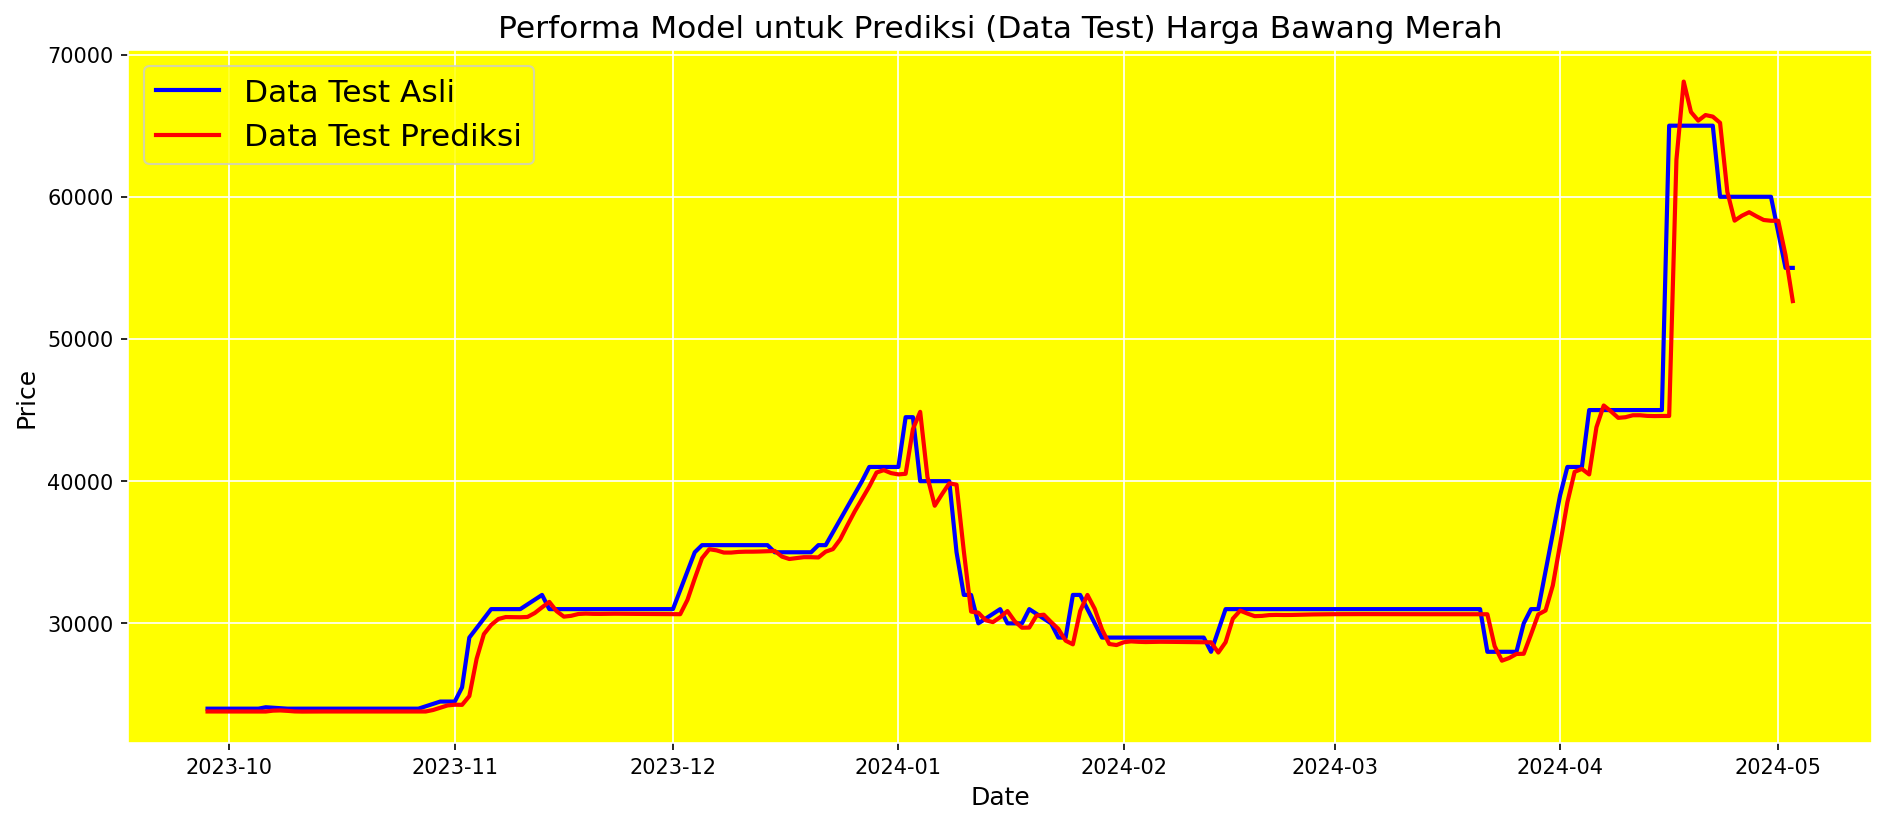

In [60]:
# Menggambar Plot Data Test Only
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.date.iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df.date.iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Performa Model untuk Prediksi (Data Test) ' + y_axis_title_comodity[comodity_selected], fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Data Test Asli', 'Data Test Prediksi'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()



> pada proses ini saya gunakan untuk melihat bagaimana persentase kesalahan hasil prediksi dengan nilai aktual



In [61]:
# Data Perbandingan dalam bentuk tabel
flatent_test_true = [item[0] for item in y_test_true]
flatent_test_pred = [item[0] for item in y_test_pred]

table_data = pd.DataFrame({
    'Date': df['date'].iloc[-test_size:],
    'Harga Asli': flatent_test_true,
    'Harga Prediksi': flatent_test_pred,
})

# Calculate the Percentage Error (often used in Mean Absolute Percentage Error or MAPE)
table_data['Persentase Error'] = (table_data['Harga Prediksi']) / (table_data['Harga Asli']  * 100)

table_data

,Date,Harga Asli,Harga Prediksi,Persentase Error
878,2023-09-28,24000.0,23802.0,0.009917
879,2023-09-29,24000.0,23801.0,0.009917
880,2023-09-30,24000.0,23800.0,0.009917
881,2023-10-01,24000.0,23799.0,0.009916
882,2023-10-02,24000.0,23799.0,0.009916
...,...,...,...,...
1092,2024-04-29,60000.0,58368.0,0.009728
1093,2024-04-30,60000.0,58313.0,0.009719
1094,2024-05-01,57500.0,58313.0,0.010141
1095,2024-05-02,55000.0,55906.0,0.010165


## Test Prediksi (Model Inference)

[[[0.351351]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [0.459459]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [1.      ]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.864865]
  [0.797297]
  [0.72973 ]
  [0.72973 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[52546.613]
 [50990.566]
 [48936.504]]


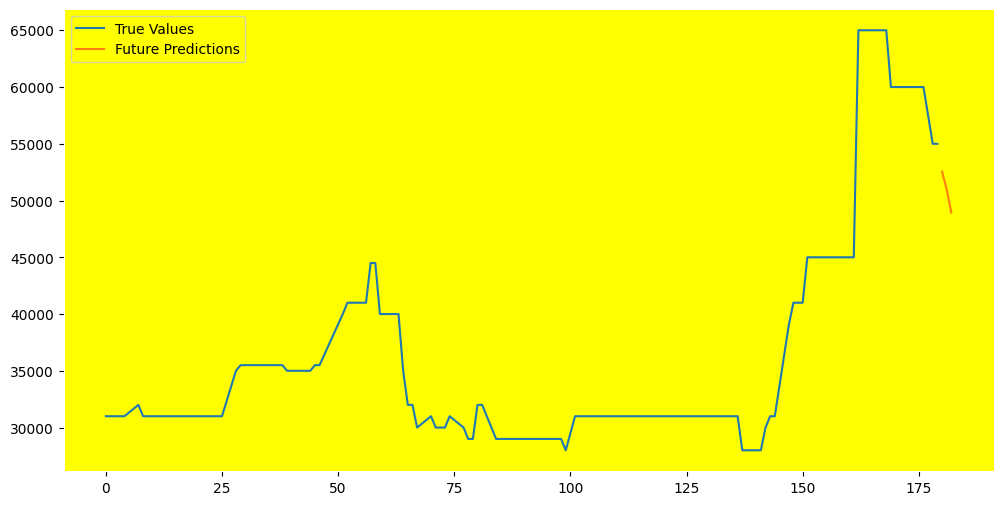

In [62]:
# Memprediksi X Hari Kedepan
target = df[comodity_list[comodity_selected]].tail(180).values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Membulatkan hingga 4 angka di belakang koma
scaled_target = np.round(scaled_target, 6)

# Predict future values
future_steps = 3  # Set the number of future steps you want to predict
future_data = scaled_target[-window_size:, :]

print(future_data.reshape((1, window_size, 1)))

future_predictions = []
for _ in range(future_steps):
    # Reshape the data to match the input shape of the model
    future_input = future_data.reshape((1, window_size, 1))

    # Make the prediction
    future_pred = model.predict(future_input)

    # Append the prediction to the results
    future_predictions.append(future_pred[0, 0])

    # Update the input data for the next prediction
    future_data = np.vstack((future_data[1:], future_pred))

# Inverse transform the predictions to the original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(future_predictions)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(target, label='True Values')
plt.plot(np.arange(len(target) , len(target) + future_steps), future_predictions, label='Future Predictions')
plt.legend()
plt.show()